In [1]:
# Import a library to fetch web content using HTTP requests.
import requests
import pandas as pd
import urllib
import os
import numpy as np
import io
# Imports the Google Cloud client library
from google.cloud import vision
from google.cloud.vision import types
import math
from src.imagerec import google_vis
from src.imagerec import distance
import json
import matplotlib.pyplot as plt
import time
from src.companies_clean import companies_clean
import random
import pickle

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import string
from nltk.corpus import stopwords
sws = set(stopwords.words('english'))
punctuation = set(string.punctuation)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier

In [3]:
final_df = pd.read_pickle('data/final_df')

In [4]:
trend_moat = pd.read_pickle('data/trend_moat')

In [5]:
image_data = pd.read_pickle('data/image_data')

In [6]:
df_google = pd.read_pickle('data/df_google')

In [7]:
df_moat = pd.read_pickle('data/df_moat')

In [8]:
df_companies = companies_clean()

In [9]:
companies_dummy = pd.get_dummies(df_companies['Categories_simple'].apply(pd.Series).stack()).sum(level=0) 

In [10]:
df_categories = pd.merge(df_companies, companies_dummy, left_index=True, right_index=True)

In [46]:
df_companies[df_companies['Organization Name'].str.contains('Ford')]
# df[df['A'].str.contains("hello")]

,Organization Name,Categories,Headquarters Location,Description,Founded,Moat Name,Categories_simple,age


In [12]:
df_companies.sample()

,Organization Name,Categories,Headquarters Location,Description,Founded,Moat Name,Categories_simple,age
447,Clover Health,"Health Care, Health Insurance, Hospital","San Francisco, California, United States",Clover Health is a new health insurance company.,2013,Clover-Health,"[Health Care, Hospital]",5


In [13]:
df_moat.sample()

,Companies Brand,Brand,Image Name,First Seen,Last Seen,Screenpath
6496,Digital-Trends,Digital Trends,Digital Trends6496.jpg,2019-04-06,2019-04-16,https://moatsearch-data.s3.amazonaws.com/creat...


In [14]:
df_moat['Last Seen'] =  pd.to_datetime(df_moat['Last Seen'])
df_moat['First Seen'] =  pd.to_datetime(df_moat['First Seen'])
df_moat['Campaign Length'] = df_moat['Last Seen'] - df_moat['First Seen']
df_moat['Campaign Length'] = df_moat['Campaign Length'].dt.days

In [15]:
color_dummy = image_data['color_round'].apply(pd.Series)

In [16]:
image_data['words'] = image_data['words'].apply(lambda x: x[1:])

In [17]:
image_data = pd.merge(image_data, color_dummy, left_index=True, right_index=True)

In [18]:
len(image_data), len(df_moat)

(4469, 9110)

In [19]:
final_df['campaign_success'] = final_df['campaign_score'] - final_df['before_score']

In [20]:
final_df['campaign_success'] = final_df['campaign_success'] >= 3

In [21]:
final_df = pd.merge(final_df, image_data, left_index=True, right_index=True)

In [22]:
final_df['one_string_words'] = final_df['words'].apply(lambda x: ' '.join(x).lower().translate(str.maketrans('', '', string.punctuation)))

In [23]:
tfidf1 = TfidfVectorizer(stop_words=sws,max_features=30000)
tfidf_description_vector = tfidf1.fit_transform(final_df['one_string_words'])
description_word_df = pd.DataFrame(tfidf_description_vector.toarray(),columns = tfidf1.get_feature_names())

In [24]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import nltk

top_N = 40


txt = final_df['one_string_words'].str.lower().str.replace(r'\|', ' ').str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(txt)
word_dist = nltk.FreqDist(words)

stopwords = nltk.corpus.stopwords.words('english')
words_except_stop_dist = nltk.FreqDist(w for w in words if w not in stopwords) 

rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency'])


In [25]:
words = [
 'get',
 'learn',
 'free',
 'shop',
 'new',
 'find',
 'business',
 'see',
 'apply',
 'today',
 'started',
 'download',
 'data',
 'report',
 'credit',
 'buy',
 'best',
 'us',
 'start',
 'join',
 'try',
 'health',
 'first',
 'security',
 'home',
 'save']

In [28]:
words_df = pd.DataFrame(columns=words)

In [29]:
for col in words_df:
    count_list =[]
    for row in range(0, len(final_df)):
        if str(col) in final_df['one_string_words'].loc[row]:
            count_list.append(1)
        else:
            count_list.append(0)
    words_df[col] = pd.Series(count_list)

In [96]:
# str('mega') in final_df['one_string_words'].loc[0]

True

In [170]:
len(words_df)

4469

In [171]:
# list(description_word_df.mean().sort_values(ascending=False).head(30).index)]

In [30]:
final_df = pd.merge(final_df, words_df, left_index=True, right_index=True)

In [25]:
# final_df[['Companies Brand',
#  'Image Name',
#  'First Seen',
#  'Last Seen',
#  'before_campaign',
#  'after_campaign',
#  'before_score',
#  'campaign_score',
#  'after_score',
#  'Brand',
#  'campaign_success',
#  'color_round']].sample()

In [31]:
test_df = pd.merge(final_df, df_companies, left_on='Companies Brand', right_on='Moat Name', how='left')

False

In [44]:
test_df.to_csv('data/words.csv')

In [27]:
test_df.drop(['Companies Brand',
 'Image Name',
 'First Seen',
 'Last Seen',
 'before_campaign',
 'after_campaign',
 'before_score',
 'campaign_score',
 'after_score',
 'Brand',
 'color_round',
 'Organization Name',
 'Categories',
 'Description',
 'Founded',
 'Moat Name',
 'Categories_simple',
 'words_x',
 'Headquarters Location',
 'one_string_words'], axis=1, inplace=True)

In [30]:
len(final_df), len(test_df)

(4469, 4519)

In [28]:
# list(test_df)

In [29]:
#vector

In [62]:
y = test_df['campaign_success']
X = test_df.drop(['campaign_success'], axis=1)
x_train,x_test,y_train,y_test = train_test_split(X,y)
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
rf.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [63]:
y_pred = rf.predict(x_test)
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

       False       0.94      0.79      0.86       888
        True       0.52      0.82      0.64       242

    accuracy                           0.80      1130
   macro avg       0.73      0.81      0.75      1130
weighted avg       0.85      0.80      0.81      1130



In [42]:
rf = RandomForestClassifier()
rf.fit(x_train,y_train)

/Users/ian/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [43]:
y_pred = rf.predict(x_test)
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

       False       0.90      0.76      0.83       887
        True       0.45      0.70      0.55       243

    accuracy                           0.75      1130
   macro avg       0.68      0.73      0.69      1130
weighted avg       0.81      0.75      0.77      1130



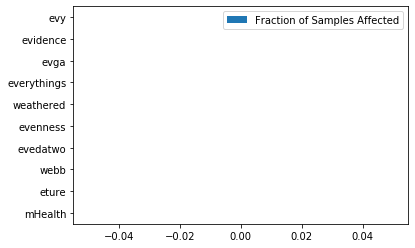

In [67]:
# Plot the feature importance
feat_scores = pd.DataFrame({'Fraction of Samples Affected' : rf.feature_importances_},
                           index=X.columns)
feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected')
feat_scores.head(10).plot(kind='barh')
plt.show()

In [ ]:
class sklearn.ensemble.GradientBoostingClassifier(loss=’deviance’, learning_rate=0.1, n_estimators=100, subsample=1.0, criterion=’friedman_mse’, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, min_impurity_split=None, init=None, random_state=None, max_features=None, verbose=0, max_leaf_nodes=None, warm_start=False, presort=’auto’, validation_fraction=0.1, n_iter_no_change=None, tol=0.0001)[source]


In [72]:
y = test_df['campaign_success']
X = test_df.drop(['campaign_success'], axis=1)
x_train,x_test,y_train,y_test = train_test_split(X,y)
rf = GradientBoostingClassifier(loss='deviance', learning_rate=0.01, n_estimators=1000, subsample=1.0, 
                                criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1,
                                min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0,
                                min_impurity_split=None, init=None, random_state=None, max_features=None, 
                                verbose=0, max_leaf_nodes=None, warm_start=False, presort='auto', validation_fraction=0.1, 
                                n_iter_no_change=None, tol=0.0001)

rf.fit(x_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [73]:
y_pred = rf.predict(x_test)
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

       False       0.97      0.74      0.84      1005
        True       0.28      0.78      0.41       125

    accuracy                           0.75      1130
   macro avg       0.62      0.76      0.62      1130
weighted avg       0.89      0.75      0.79      1130



In [ ]:
tf = TfidfVectorizer(analyzer='word', 
                     min_df=10,
                     ngram_range=(1, 2),
                     stop_words='english')
svd = TruncatedSVD(n_components=5)

#Fit tfidf and svd, and transform training data
tfidf_matrix = tf.fit_transform(wine.description)
lsa_features = pd.DataFrame(svd.fit_transform(tfidf_matrix))

#Creat meaningful column names
collist = map(str, range(0, 5))
collist = ["latent_description_" + s for s in collist]
lsa_features.columns = collist
lsa_features.head()

In [238]:
master_test = []
master_color = []
for i in df2['Image Name'][0:2]:
    temp_list = google_vis(i)
    master_color.append(temp_list[0])
    master_test.append(temp_list[1])

In [58]:
for i in temp.keys():
    temp[i] = sum(d[i] for d in master_color) / len(master_color)

In [67]:
temp

{'apricot': 0.0032384962785047488,
 'beige': 0.009949879656842613,
 'black': 0.1343126305721823,
 'blue': 0.055156006915290115,
 'brown': 0.011209728710537593,
 'cyan': 0.013267482582295497,
 'green': 0.0025704831939067814,
 'grey': 0.0365737178593178,
 'lavender': 0.002331209507167012,
 'lime': 0.019611653672265156,
 'magenta': 9.180297358677938e-05,
 'maroon': 0.027092619517633875,
 'mint': 0.012284019117622258,
 'navy': 0.0395328986412426,
 'olive': 0.001737420073618273,
 'orange': 0.014232390478335239,
 'pink': 0.032091974741318724,
 'purple': 7.71535611660271e-05,
 'red': 0.07705394494869225,
 'teal': 0.005716199758923152,
 'white': 0.47037889168004154,
 'yellow': 0.03148939555950954}

In [65]:
temp = {'apricot': 0,
     'beige': 0,
     'black': 0,
     'blue': 0,
     'brown': 0,
     'cyan': 0,
     'green': 0,
     'grey': 0,
     'lavender': 0,
     'lime': 0,
     'magenta': 0,
     'maroon': 0,
     'mint': 0,
     'navy': 0,
     'olive': 0,
     'orange': 0,
     'pink': 0,
     'purple': 0,
     'red': 0,
     'teal': 0,
     'white': 0,
     'yellow': 0}

In [81]:
color_list = temp.keys()

In [85]:
color_list = ['pink', 'beige', 'black', 'blue', 'brown', 'cyan', 'green', 'grey', 'lavender', 'lime', 'magenta', 'maroon', 'green', 'navy', 'olive', 'orange', 'pink', 'purple', 'red', 'teal', 'white', 'yellow']

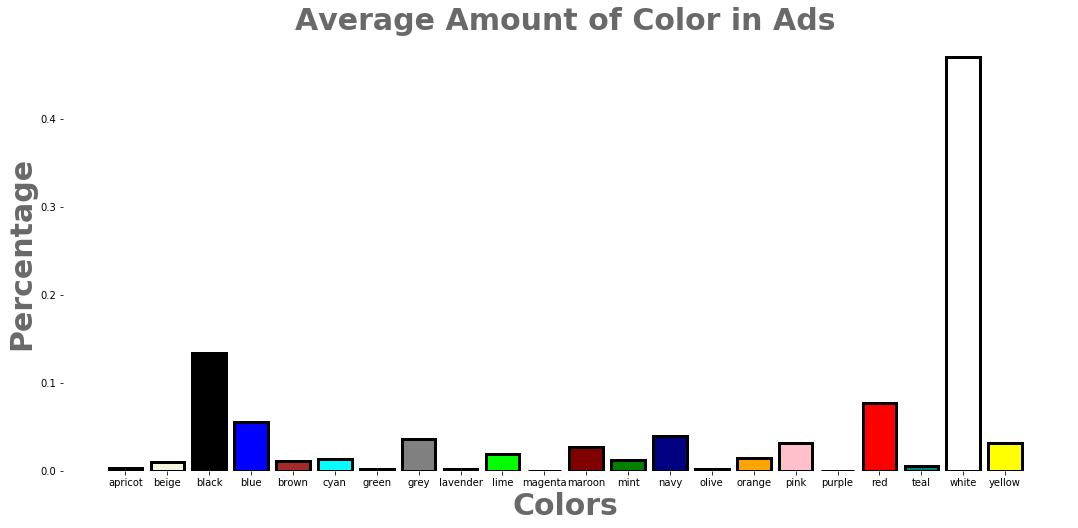

In [141]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (18,8))
pos = np.arange(len(temp.values()))
width = 1.0     # gives histogram aspect to the bar diagram

ax = plt.axes()
# ax.set_xticks()
font = {'fontname' : 'Myriad Hebrew',
        'weight' : 'bold',
        'size'   : 30,
       'color': 'dimgray'}

from pylab import *
axes(frameon = 0)
ax.set_xticklabels(color_list, rotation=90)
plt.ylabel('Percentage', fontdict=font)
plt.title('Average Amount of Color in Ads', fontdict=font)

plt.xlabel('Colors',fontdict=font)
plt.bar(temp.keys(), temp.values(), color=color_list, edgecolor="black", lw=3)                       
plt.show()

In [8]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import pandas as pd
import numpy as np

In [3]:
image_data = pd.read_pickle('word_cloud')

In [23]:
str1 = '\n'.join(''.join(sub) for sub in image_data)

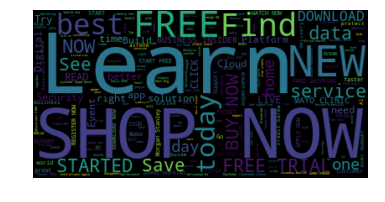

In [26]:
# Create and generate a word cloud image:
wordcloud = WordCloud().generate(str1)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

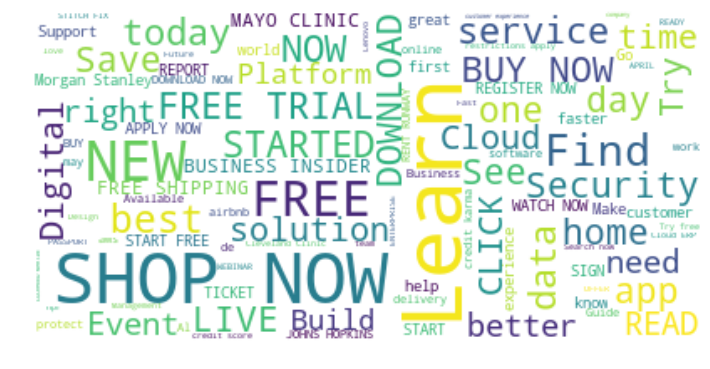

In [28]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(str1)
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig('wordjumble', dpi=500, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0,
        frameon=None, metadata=None)
plt.show()

In [ ]:
'''this function has been copied into get_images.py'''


# def get_images(df_companies=df_companies, start_row = 0, file_path='/Users/ian/Documents/week3/Capstone1/images/')   
#     """
#         A scrapy splash bot which pushes data requests into MOAT.com to grab creative along with information about when
#         it was live
        
#         Parameters
#         ----------
#         df_companies : pandas dataframe : str
#             must have a column titled 'Moat Name' with a list of companies for the bot to iterate through
            
#         start_row : int
#             if the function errors out due to moat sending unprocessable data, the function might need to be restarted from a 
#             specific point within df_companies
            
#         file_path : str
#             the location to save images to disc
            
#         returns:
#             a pandas dataframe with the following columns
#             'Companies Brand','Brand','Image Name','First Seen','Last Seen','Screenpath'
#         """
    
#     #creates an empty dataframe for the MOAT data to be populated into
#     df_moat = pd.DataFrame(columns=['Companies Brand','Brand','Image Name','First Seen','Last Seen','Screenpath'])

#     #pulls in a count with the total number of images saved through this function. Used for naming convention when saving 
#     #files to disc
#     test = open('master_count.txt','r') 
#     master_count = int(test.read())

#     # iterates through the company names and 
#     for company in list(df_companies['Moat Name'][start_row:]):
#         #push a from request into MOAT's AWS server and returns JSON with pathname information to access a companies creatives
#         URL = 'https://moat.com/api/entity_report/advertiser/'+company+'/creatives_query_info?end_date=2019-06-26&filter=all&report_type=display&start_date=2012-05-01'
#         # Get the HTML content of the web page as a string.
#         content = requests.get(URL).content
#         #load content into JSON
#         f = json.loads(content)
#         time.sleep(4)

#         #this portion of the function uses scrapy splash to grab information regarding the creative and saves it into a dataframe
#         #along with the image which is saved to disc

#         # page range will determine how many pages of creatives to pull from the company
#         for page_num in range(0,2):
#             try:
#                 # takes the JSON requested above and iterates through AJAX JSON files to grab creative information and link locations
#                 URL = 'https://moat.com'+(f['base_creative_url'])+'?device=desktop&device=mobile&end_date='+f['max_date']+'&filter=all&load_time='+str(f['load_time'])+'&page='+str(page_num)+'&page_size=42&period=month&report_type=display&start_date='+f['min_date']+'&time_hash='+f['time_hash']
#                 # Get the HTML content of the web page as a string.
#                 content = requests.get(URL).content
#                 #load content into JSON
#                 j = json.loads(content)
#                 for i in range(len(j['creative_data'])):
#                     #checks to see if the creative being examined is a 300x250
#                     if (j['creative_data'][i]['dims'][0] == 300) & (j['creative_data'][i]['dims'][1] == 250):
#                         df_moat.loc[master_count] = str(company),j['creative_data'][i]['brand']['name'], j['creative_data'][i]['brand']['name']+str(master_count)+'.jpg', j['creative_data'][i]['first_seen'], j['creative_data'][i]['last_seen'], j['creative_data'][i]['screenpath']
#                         #saves the image down to drive
#                         urllib.request.urlretrieve(j['creative_data'][i]['screenpath'],file_path +j['creative_data'][i]['brand']['name']+str(master_count)+'.jpg')
#                         #master count is used to create a unique creative name which will allows google creative 
#                         #cloud to read and parce each component
#                         master_count += 1
#             except:
#                 continue       
#             time.sleep(random.randint(18,25))

#     # changes the datetime columns type
#     df_moat['First Seen'] = pd.to_datetime(df_moat['First Seen'])
#     df_moat['Last Seen'] = pd.to_datetime(df_moat['Last Seen'])
#     #adds two new columns with dates before the campaign started and after it ended
#     df_moat['before_campaign'] = df_moat['First Seen'] - pd.DateOffset(months=4)
#     df_moat['after_campaign'] = df_moat['Last Seen'] + pd.DateOffset(months=4)

#     # saves the master count from creatives to a .txt file
#     with open('master_count.txt', 'w') as f:
#         f.write(str(master_count))
        
#     return df_moat

In [ ]:
# df[df['Organization Name'].str.match('SunPower')]